# OpenWebText Pipeline Profiling Analysis

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH HDDs
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 80GB DDR4

All plots that are not saved with the `save_fig` function were not used in the paper, but may provide a close-up look on specific values.


### Meta information

* Dataset size: `7.713` GB 
* Amount of `.txt` files: `180662` (`find . -type f | grep .txt | wc -l`)
* Avg. filesize: `0.04269` MB
* Sample sizes (rounded to second decimal):
    * `0500:   21.35 MB` 
    * `1000:   42.69 MB`
    * `2000:   85.39 MB`
    * `4000:  170.78 MB`
    * `8000:  341.56 MB`

In [8]:
full_dataset_samplecount = 180662
running_sample_count = 500 # full_dataset_samplecount

500 of total: 0.28%
1000 of total: 0.55%
2000 of total: 1.11%
4000 of total: 2.21%
8000 of total: 4.43%


In [9]:
%load_ext autoreload
%autoreload 2
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import ticker
import matplotlib.patches as mpatches

from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from notebookhelper import show_values_on_bars, show_values_on_catplot, save_figure, make_big_number_prettier \
                         , make_big_number_prettier_storage_mb

from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
epoch_palette = sns.color_palette("YlOrRd", 3)
samples_palette = sns.color_palette("icefire", 15)
threads_palette = sns.color_palette("tab20", 4)
compression_palette = sns.color_palette("Spectral",3)
font_scale = 1.4
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
local_fig_dir = "openwebtext-pipeline"

def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

log_path = "/logs/"
path_to_cum_df = f"{log_path}/full-log_cum-df.csv"
path_to_cum_dstat_df = f"{log_path}/full-log_cum-dstat-df.csv"
sampling_tag = ""

analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                   , path_to_cum_df = path_to_cum_df)
cum_dstat_df = analysis.to_cum_dstat_df()
cum_df       = analysis.to_cum_df()
# need to sort the strategies for some reason as they are not ascending
cum_df = cum_df.sort_values(by='split_name')
strategies   = list(cum_df.split_name.unique())
strategies_renamed = ["unprocessed", "concatenated", "decoded", "bpe-\nencoded", "embedded"]

['0-fully-online', '1-read-files', '2-extract-content', '3-byte-pair-encoding', '4-lookup-embedding']


# 1. Storage Consumption vs Throughput Tradeoffs
### Full dataset, 8 threads, epoch 0

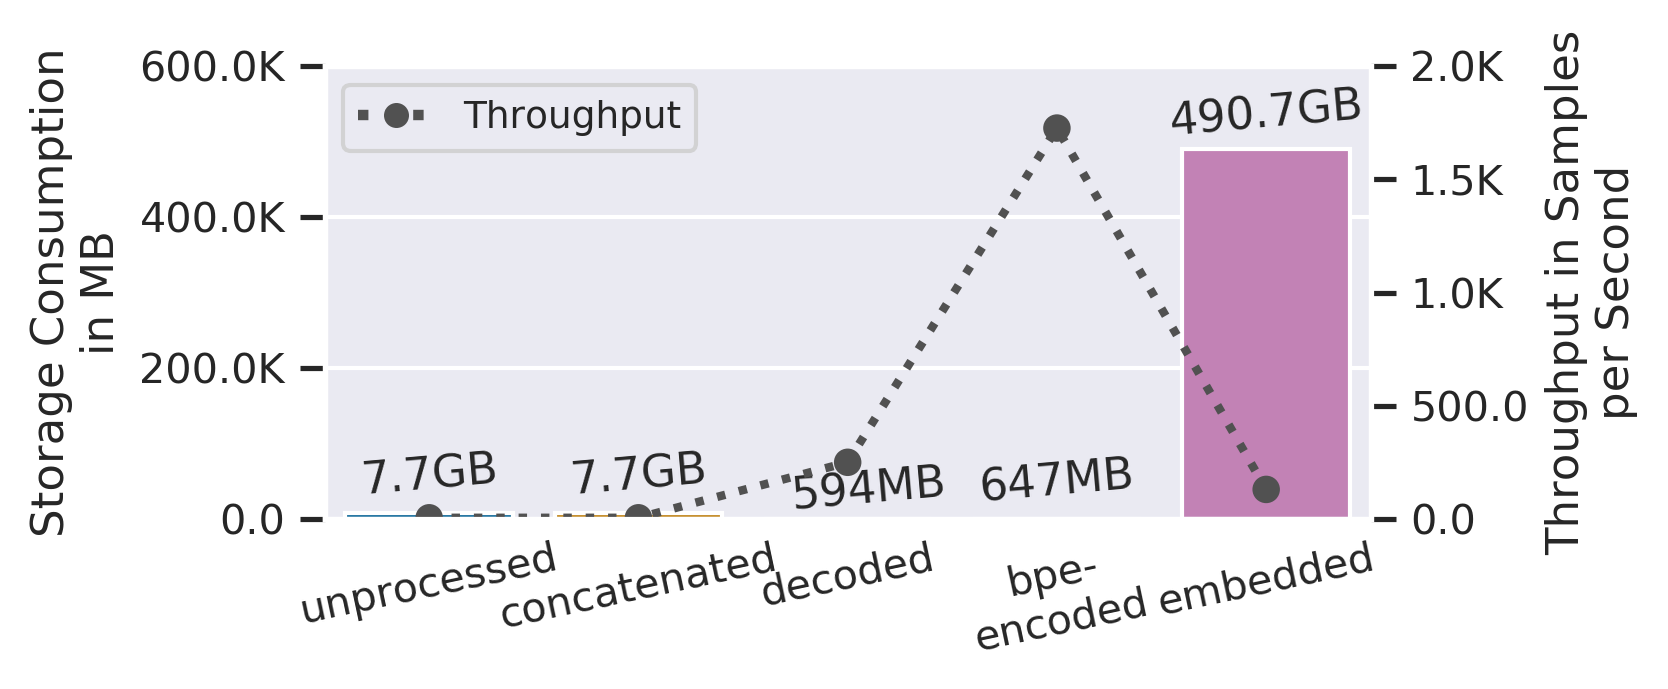

In [14]:
cum_df_temp = cum_df.query(f"sample_count=={running_sample_count} \
                         and thread_count==8 \
                         and runs_count==0 \
                         and compression_type=='none'")

sample_size_mb_dict = {
    "500": 21.35
  , "1000": 42.69
  , "2000": 85.39
  , "4000": 170.78
  , "8000": 341.56
  , f"{full_dataset_samplecount}": 7713.00
}

storage_consumption_comparison = {
    "storage_consumption_mb": []
  , "sample_count": []
  , "strategy": []
}

def add_to_dict(size, sample_count, label):
    '''Short helper'''
    storage_consumption_comparison["storage_consumption_mb"] += [size]
    storage_consumption_comparison["sample_count"] += [sample_count]
    storage_consumption_comparison["strategy"] += [label]
    
for sample_count in cum_df_temp.sample_count.unique():
    for i, strategy in enumerate(strategies):
        shard_sizes_mb = cum_df_temp.query(f"split_name=='{strategy}' and sample_count=={sample_count}")["shard_cum_size_MB"].to_numpy()
        for size_mb in shard_sizes_mb:
            if i == 0: # i.e., unprocessed
                size_mb = sample_size_mb_dict[str(sample_count)]
            add_to_dict(size = size_mb
                      , sample_count = sample_count
                      , label = strategies[i])

storage_df = pd.DataFrame(storage_consumption_comparison)

from matplotlib.lines import Line2D

sns.set(palette=default_palette, font_scale=0.9)
throughput_color = "#515151"
marker = 'o'
linestyle = ":"

fig, ax1 = plt.subplots(figsize=(4.5,2))
ax2 = ax1.twinx()
#sns.set(font_scale=1.4)

## throughput plot
plot2 = sns.pointplot(x="split_name", y="throughput_sps", data=cum_df_temp,
                      ax=ax2, scale=0.75, color=throughput_color, linestyles=linestyle, ci=0.95, marker='o')

plot2.set(ylabel="Throughput in Samples\nper Second")
ax2.grid(False)
legend_elements = [Line2D([0], [0], marker=marker, markersize=5, color=throughput_color, lw=2.5, label='Throughput', linestyle=linestyle)]
ax2.legend(handles=legend_elements, loc="upper left", prop={'size': 9})
plot2.set(ylim=(0, 2000))          

plot = sns.barplot(
        x="strategy",
        y="storage_consumption_mb",
        data=storage_df.query(f"sample_count=={running_sample_count}"),
        ax=ax1
    )
plot.set_xticklabels(
    strategies_renamed
  , rotation=12
)
plot.tick_params(axis='x', which='major', pad=-1.5)
show_values_on_bars(plot, h_v="v", space=40000, rotation=5, storage_formatting=True,
                       additional_space=[0,0,-10000,0,0]
                      ,additional_x_space=[0,0,0.1,0,0])
plot.set(ylabel="Storage Consumption\nin MB", xlabel="")
plot.set(ylim=(0, 600000))

plot.yaxis.set_major_formatter(make_big_number_prettier)
plot2.yaxis.set_major_formatter(make_big_number_prettier)
save_fig("storage-vs-throughput")

# 2. Caching Analysis
### Full dataset, 8 threads, epoch 0 + 1

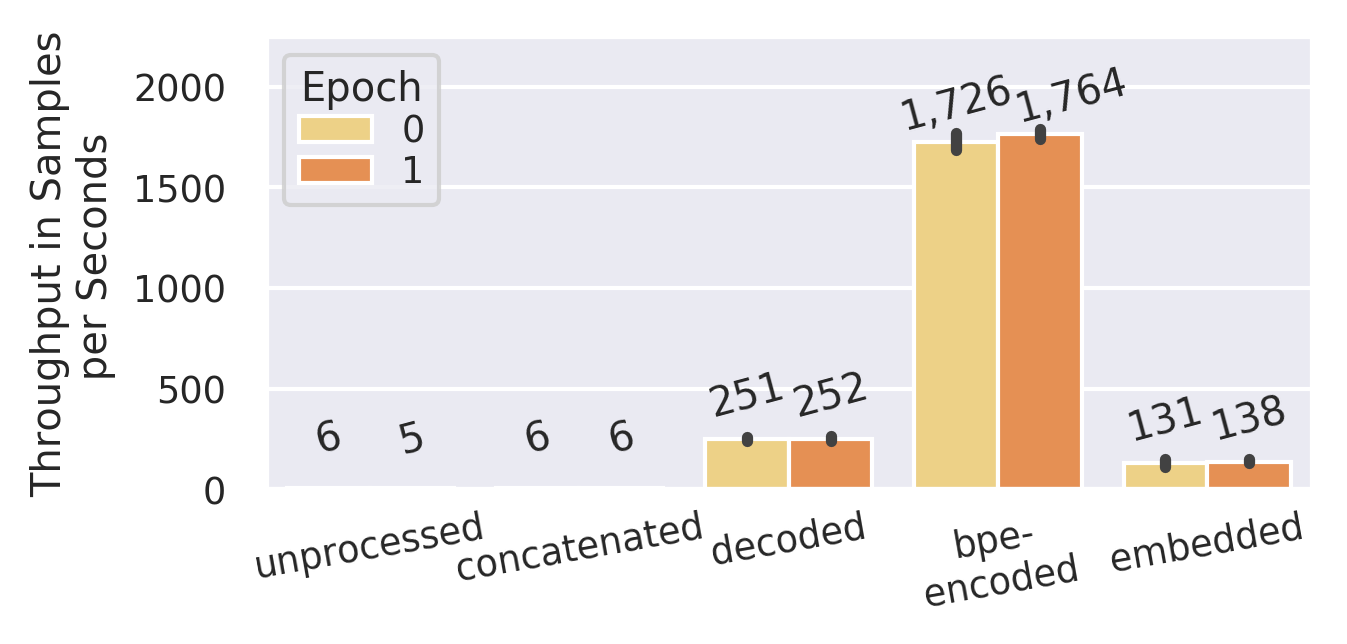

In [15]:
sns.set(palette=epoch_palette, font_scale=0.8)

cum_df_temp = cum_df.query(f"sample_count=={running_sample_count} \
                         and thread_count==8 and runs_count<=1 and compression_type=='none'")

plt.figure(figsize=(4.5,2))
plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="runs_count",
    data=cum_df_temp
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-1.5)
plot.set(xlabel="", ylabel="Throughput in Samples\n per Seconds")
plot.set(ylim=(0, 2250))
plot.legend(title="Epoch", ncol=1, labelspacing=0.1, loc="upper left")
show_values_on_bars(plot, h_v="v", space=200, rotation=15, additional_x_space=[0,0,0,0,0
                                                                              ,0,0,0,0.15,0])
save_fig("caching-over-epochs")

# 3. Parallelism
### Normalizing the processing time per samples and renaming the maximum sample count to "full"

In [16]:
# calculate the per sample processing time for both offline and online processing
cum_df["per_sample_online_processing_time_s"] = cum_df["online_processing_time_s"] / cum_df["sample_count"]
cum_df["per_sample_offline_processing_and_save_time_s"] = cum_df["offline_processing_and_save_time_s"] / cum_df["sample_count"]
# calculate the total processing time for each sample count
cum_df["total_processing_time_s"] = cum_df["online_processing_time_s"] + cum_df["offline_processing_and_save_time_s"]
# extrapolate based on the full count of images
cum_df["full_dataset_online_processing_time_s"] = cum_df["per_sample_online_processing_time_s"] * full_dataset_samplecount
cum_df["full_dataset_offline_processing_and_save_time_s"] = cum_df["per_sample_offline_processing_and_save_time_s"] * full_dataset_samplecount
cum_df["full_dataset_offline_processing_and_save_time_m"] = cum_df["full_dataset_offline_processing_and_save_time_s"] / 60
cum_df["full_dataset_offline_processing_and_save_time_h"] = cum_df["full_dataset_offline_processing_and_save_time_m"] / 60


# sum the offline and online time for the full dataset processing time (converted to hours)
cum_df["full_dataset_processing_time_s"] = cum_df["full_dataset_online_processing_time_s"] + cum_df["full_dataset_offline_processing_and_save_time_s"]
cum_df["full_dataset_processing_time_m"] = cum_df["full_dataset_processing_time_s"] / 60
cum_df["full_dataset_processing_time_h"] = cum_df["full_dataset_processing_time_m"] / 60 


cum_df_mod = cum_df.copy(deep=True)
cum_df_mod.loc[cum_df_mod.sample_count == 180662, 'sample_count'] = '181K (full)'
order_dict = { 500: 10, 1000: 11, 2000: 12, 4000: 13, 8000: 14, '181K (full)': 15}
strategy_order_dict = dict(list(enumerate(strategies)))
strategy_order_dict = dict({(y, x) for x, y in strategy_order_dict.items()})
order_dict.update(strategy_order_dict)
cum_df_mod = cum_df_mod.sort_values(by=['split_name', 'sample_count'], key=lambda x: x.map(order_dict))

In [24]:
pd.set_option('display.max_rows', None)
#cum_8000_df = cum_df_mod.query("sample_count==8000  and compression_type=='none'")
cum_8000_df = cum_df_mod.query(f"sample_count=={running_sample_count}  and compression_type=='none'")

parallel_capability = {
      "thread_count": []
    , "strategy": []
    , "speedup": []
    , "run": []
}

def add_capability(thread_count, strategy, speedup, run):
    parallel_capability["thread_count"] += [thread_count]
    parallel_capability["strategy"] += [strategy]
    parallel_capability["speedup"] += [speedup]
    parallel_capability["run"] += [run]

for strategy in strategies:
    for run_count in cum_df.runs_count.unique():
        for thread_count in cum_df.thread_count.unique():
            throughputs = cum_8000_df.query(f"thread_count=={thread_count} and split_name=='{strategy}' and runs_count=={run_count}")["throughput_sps"].to_numpy()
            for throughput in throughputs:
                avg_step_t1_throughput = cum_8000_df.query(f"thread_count=={1} and split_name=='{strategy}' and runs_count=={run_count}")["throughput_sps"].mean()
                # not using percentages here as I feel its more intuitive, benchmarking crimes is still followed from my understanding
                #if avg_step_t1_throughput < throughput:
                #    rel_increase_factor =  throughput / avg_step_t1_throughput - 1
                #    add_capability(thread_count, strategy, np.round(rel_increase_factor, 2))
                #else:
                #    rel_decrease_factor = 1 - throughput / avg_step_t1_throughput
                #    add_capability(thread_count, strategy, -np.round(rel_decrease_factor, 2))
                ## now using speedup instead of increase/decrease factor
                speedup = throughput / avg_step_t1_throughput
                add_capability(thread_count, strategy, speedup, run_count)

parallel_capability_df = pd.DataFrame(parallel_capability)

,thread_count,strategy,speedup,run
197,1,2-extract-content,0.990615,0
304,1,3-byte-pair-encoding,1.057927,0
303,1,3-byte-pair-encoding,0.953973,0
188,1,2-extract-content,1.018003,0
301,1,3-byte-pair-encoding,0.992202,0
300,1,3-byte-pair-encoding,1.009088,0
299,1,3-byte-pair-encoding,0.988049,0
77,1,1-read-files,1.016938,0
78,1,1-read-files,0.963068,0
79,1,1-read-files,0.979743,0


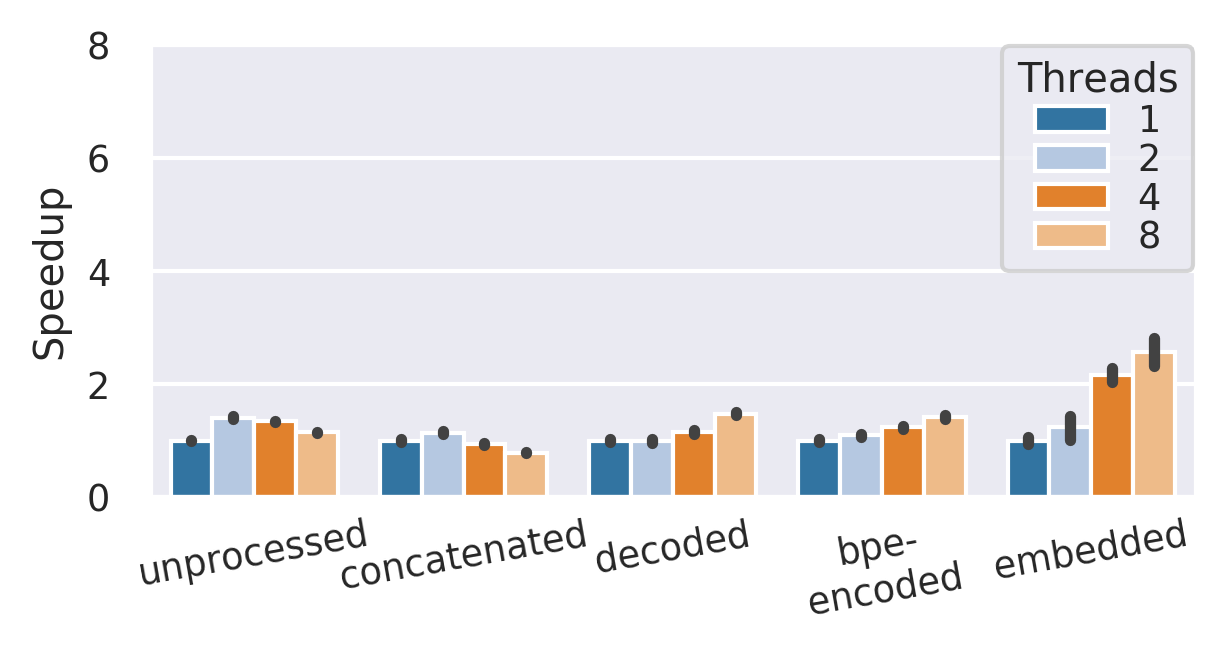

In [50]:
sns.set(palette=threads_palette, font_scale=0.8)

plt.figure(figsize=(4.5,2))
plot = sns.barplot(
    x="strategy",
    y="speedup",
    hue="thread_count",
    data=parallel_capability_df.query("run==0")
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-1.5)
#plot.set_title(f"Caching Speedup")
plot.set(xlabel="", ylabel="Speedup")
plot.set(ylim=(0, 8))
plot.legend(title="Threads", ncol=1,labelspacing=0.05, loc=(0.815,0.5))
save_fig("speedup-8000-samples-epoch-0")

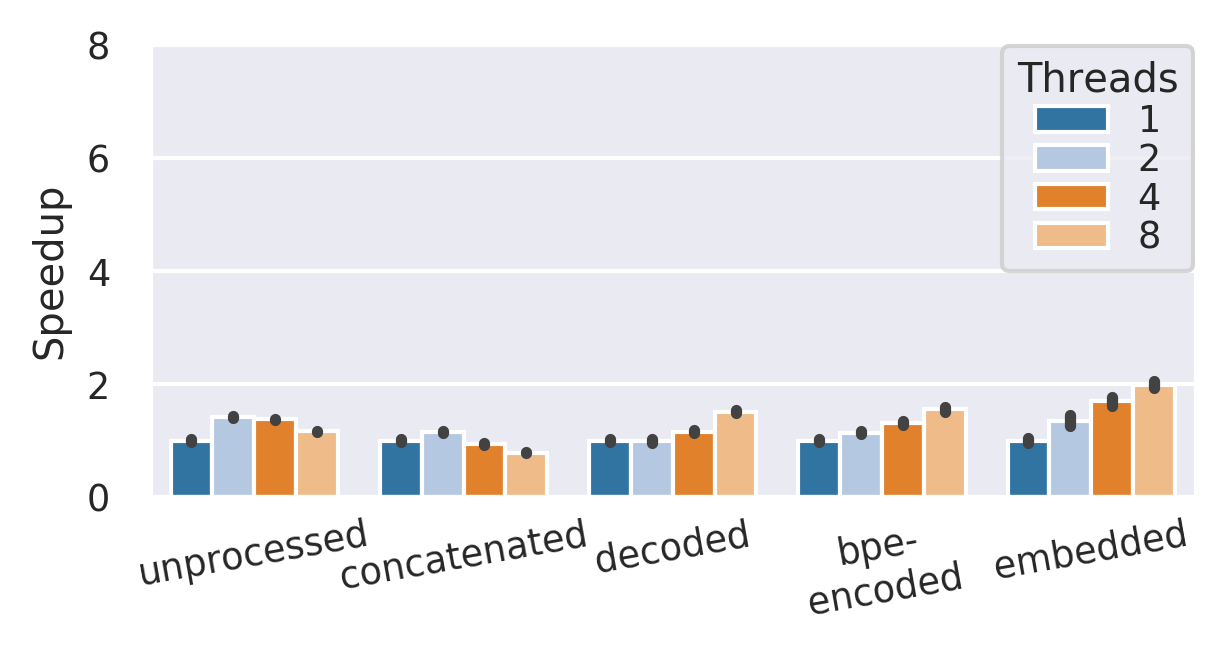

In [51]:
sns.set(palette=threads_palette, font_scale=0.8)

plt.figure(figsize=(4.5,2))
plot = sns.barplot(
    x="strategy",
    y="speedup",
    hue="thread_count",
    data=parallel_capability_df.query("run==1")
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-1.5)
#plot.set_title(f"Caching Speedup")
plot.set(xlabel="", ylabel="Speedup")
plot.set(ylim=(0, 8))
plot.legend(title="Threads", ncol=1,labelspacing=0.05, loc=(0.815,0.5))
save_fig("speedup-8000-samples-epoch-1")

In [ ]:
cum_df_ord = cum_df.copy(deep=True).query(f"thread_count==8 and runs_count==0 and split_name!='0-fully-online' and sample_count=={running_sample_count}")
order_dict = { "none": 10, "GZIP": 11, "ZLIB": 12 }
cum_df_ord = cum_df_ord.sort_values(by=["compression_type", "split_name"], key=lambda x: x.map(order_dict))
strategies_renamed = ["concatenated", "decoded", "bpe-\nencoded", "embedded"]
cum_df_temp = cum_df_ord

In [ ]:
from matplotlib.lines import Line2D

sns.set(palette=compression_palette,font_scale=0.8)
marker = 'o'
linestyle = [(10,2), (4,5), (1,2)]
linestyle2 = [(0,(10,2)), (0,(4,5)), (0,(1,2))]

fig, ax1 = plt.subplots(figsize=(4.5,2))
ax2 = ax1.twinx()

## throughput plot
plot2 = sns.lineplot(
    x="split_name",
    y="throughput_sps",
    hue="compression_type",
    data=cum_df_temp,
    ax=ax2,
    size=3,
    sizes=(3,3),
    marker=marker,
    dashes=linestyle,
    ci=0.95,
    markeredgecolor='black',
    style='compression_type')

plot2.set(ylabel="Throughput in Samples\nper Second")
ax2.grid(False)
legend_elements = [
    Line2D([0], [0], marker=marker, markeredgecolor='#000000', markeredgewidth=0.5, markersize=5, lw=0.9, label='none', color="#E49467", linestyle=linestyle2[0]),
    Line2D([0], [0], marker=marker, markeredgecolor='#000000', markeredgewidth=0.5, markersize=5, lw=1.5, label='GZIP', color="#F7F7C6", linestyle=linestyle2[1]),
    Line2D([0], [0], marker=marker, markeredgecolor='#000000', markeredgewidth=0.5, markersize=5, lw=2.5, label='ZLIB', color="#90C6A6", linestyle=linestyle2[2])]
ax2.legend(handles=legend_elements, loc="upper left", prop={'size': 9})
plot2.set(ylim=(0, 2250))        

plot = sns.barplot(
        x="split_name",
        y="shard_cum_size_MB",
        hue="compression_type",
        data=cum_df_temp,
        ax=ax1
    )
plot.set_xticklabels(
    strategies_renamed
  , rotation=5
)
plot.tick_params(axis='x', which='major', pad=-1.5)
plot.set(ylabel="Storage Consumption\nin MB", xlabel="")
plot.yaxis.set_major_formatter(make_big_number_prettier)
show_values_on_bars(plot, h_v="v", space=100000, rotation=15, storage_formatting=True
                    , additional_space=[30000,   50000,40000,-50000
                                       ,5000,     5000,5000,0
                                       ,-20000, -40000, -20000,-50000
                                       ]
                    , additional_x_space=[0.05,0.1,0.1,0,
                                          0,-0.05,0.05,0,
                                          0,0.05,0.05,-0.09])

plot.set(ylim=(0, 600000))
ax1.get_legend().remove()
plot.yaxis.set_major_formatter(make_big_number_prettier)
plot2.yaxis.set_major_formatter(make_big_number_prettier)
save_fig("compressed-storage-vs-throughput")

In [ ]:
# calculate the per sample processing time for both offline and online processing
cum_df_ord["per_sample_online_processing_time_s"] = cum_df_ord["online_processing_time_s"] / cum_df_ord["sample_count"]
cum_df_ord["per_sample_offline_processing_and_save_time_s"] = cum_df_ord["offline_processing_and_save_time_s"] / cum_df_ord["sample_count"]
# calculate the total processing time for each sample count
cum_df_ord["total_processing_time_s"] = cum_df_ord["online_processing_time_s"] + cum_df_ord["offline_processing_and_save_time_s"]
# extrapolate based on the full count of images
cum_df_ord["full_dataset_online_processing_time_s"] = cum_df_ord["per_sample_online_processing_time_s"] * full_dataset_samplecount
cum_df_ord["full_dataset_offline_processing_and_save_time_s"] = cum_df_ord["per_sample_offline_processing_and_save_time_s"] * full_dataset_samplecount
cum_df_ord["full_dataset_offline_processing_and_save_time_m"] = cum_df_ord["full_dataset_offline_processing_and_save_time_s"] / 60
cum_df_ord["full_dataset_offline_processing_and_save_time_h"] = cum_df_ord["full_dataset_offline_processing_and_save_time_m"] / 60

# sum the offline and online time for the full dataset processing time (converted to hours)
cum_df_ord["full_dataset_processing_time_s"] = cum_df_ord["full_dataset_online_processing_time_s"] + cum_df_ord["full_dataset_offline_processing_and_save_time_s"]
cum_df_ord["full_dataset_processing_time_m"] = cum_df_ord["full_dataset_processing_time_s"] / 60
cum_df_ord["full_dataset_processing_time_h"] = cum_df_ord["full_dataset_processing_time_m"] / 60 

In [ ]:
cum_df_temp = cum_df_ord
sns.set(palette=compression_palette, font_scale=0.8)
fig, ax1 = plt.subplots(figsize=(4.5,2))

plot = sns.barplot(
    x="split_name",
    y="full_dataset_processing_time_h",
    hue="compression_type",
    data=cum_df_temp
)
plot = sns.barplot(
    x="split_name",
    y="full_dataset_offline_processing_and_save_time_h",
    hue="compression_type",
    data=cum_df_temp,
    color="grey"
)

plot.set_xticklabels(
    strategies_renamed
  , rotation=5
)
plot.tick_params(axis='x', which='major', pad=-1.5)

sample_counts = len(cum_df_temp.compression_type.unique())
strategies_count = len(cum_df_temp.split_name.unique())

for i,bar in enumerate(plot.patches):
    if i > (sample_counts * strategies_count):
        bar.set_hatch("//")

plot.set(xlabel="", ylabel="Time in Hours")
plot.set(ylim=(0, 12))

handles, labels = plot.get_legend_handles_labels()

def add_status_to_handle(handle, index):
    compression_count = 3
    label = handle.get_label()
    if index >= compression_count:
        new_label = label + ' (offline)'
    else:
        new_label = label + ' (online)'
    handle.set_label(new_label)
    
for i, handle in enumerate(handles):
    add_status_to_handle(handle,index=i)

plot.legend(handles=handles, title="", loc="lower right", ncol=1, labelspacing=0.02, columnspacing=0.3)
save_fig("compression-processing-time-split")